In [1]:
!pip install ta

  Using cached ta-0.11.0-py3-none-any.whl


In [2]:
!pip install openpyxl

  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)


# Importation des bibliothèques nécessaires

In [3]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from sklearn.metrics import hamming_loss
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer


# Chargement des données

In [4]:
df = pd.read_excel('Historiques_cours_boursiers.xlsx' , sheet_name=None)

# Prétraitement des données

In [5]:
# Sélection de 6 indices parmi les 13 disponibles
indices_selectionnes = ['AMZN', 'AAPL', 'GOOG', 'NVDA', 'TSLA','MSFT']

In [6]:
# Création d'un dictionnaire pour stocker les DataFrames de chaque indice
df_dict = {}

for indice in indices_selectionnes:
    df_dict[indice] = df[indice].set_index('Date')

In [7]:
df_dict['AAPL']

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.847207,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.775779,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.787131,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.719014,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.753073,460734400
...,...,...,...,...,...,...
2023-12-14,198.020004,199.619995,196.160004,198.110001,198.110001,66831600
2023-12-15,197.529999,198.399994,197.000000,197.570007,197.570007,128256700
2023-12-18,196.089996,196.630005,194.389999,195.889999,195.889999,55751900


# Variable à expliquer 

In [8]:
def generer_variable_cible(row, close_shifted):
    variation_pct = (close_shifted / row['Close'] - 1) * 100
    return pd.cut(variation_pct, bins=[float('-inf'), -2, 2, float('inf')], labels=['Baisse', 'Stable', 'Hausse'], include_lowest=True)

# Appliquer les règles pour chaque indice
for indice, df_indice in df_dict.items():
    close_shifted = df_indice['Close'].shift(-5)
    df_indice['Variable_Cible'] = generer_variable_cible(df_indice, close_shifted)

    # Supprimer les lignes avec des valeurs manquantes
    df_dict[indice] = df_indice.dropna()


In [9]:
df_dict['AAPL']

,Open,High,Low,Close,Adj Close,Volume,Variable_Cible
Date,,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.847207,535796800,Baisse
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.775779,512377600,Baisse
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.787131,778321600,Baisse
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.719014,767972800,Stable
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.753073,460734400,Stable
...,...,...,...,...,...,...,...
2023-12-07,193.630005,195.000000,193.589996,194.270004,194.270004,47477700,Stable
2023-12-08,194.199997,195.990005,193.669998,195.710007,195.710007,53377300,Stable
2023-12-11,193.110001,193.490005,191.419998,193.179993,193.179993,60943700,Stable


on a creé la variable cible (Baisse, Stable, Hausse)

# Variables explicatives

on commence par crée la variable MACD

In [10]:
# Définir les paramètres du MACD
short_window = 12
long_window = 26
signal_window = 9

In [ ]:
# Boucle à travers chaque indice financier et son DataFrame associé
for indice, df_indice in df_dict.items():
    
    # Calcul de la moyenne mobile exponentielle courte (Short EMA)
    df_indice['Short_EMA'] = df_indice['Close'].ewm(span=short_window, adjust=False).mean()
    
    # Calcul de la moyenne mobile exponentielle longue (Long EMA)
    df_indice['Long_EMA'] = df_indice['Close'].ewm(span=long_window, adjust=False).mean()
    
    # Calcul de la différence entre Short EMA et Long EMA (MACD)
    df_indice['MACD'] = df_indice['Short_EMA'] - df_indice['Long_EMA']
    
    # Calcul de la moyenne mobile exponentielle du MACD (Signal Line)
    df_indice['Signal_Line'] = df_indice['MACD'].ewm(span=signal_window, adjust=False).mean()
    
    # Calcul de l'histogramme du MACD
    df_indice['MACD_Histogram'] = df_indice['MACD'] - df_indice['Signal_Line']
    
    # Suppression des colonnes non nécessaires (Short EMA, Long EMA, Signal Line)
    columns_to_drop = ['Short_EMA', 'Long_EMA', 'Signal_Line']
    df_indice.drop(columns=columns_to_drop, axis=1, inplace=True)


In [12]:
'''for indice, df_indice in df_dict.items():
    df_indice['Signal'] = 0
    df_indice.loc[df_indice['MACD'] > 0, 'Signal'] = 1
    df_indice.loc[df_indice[ 'MACD'] < 0,  'Signal'] = -1'''

"for indice, df_indice in df_dict.items():\n    df_indice['Signal'] = 0\n    df_indice.loc[df_indice['MACD'] > 0, 'Signal'] = 1\n    df_indice.loc[df_indice[ 'MACD'] < 0,  'Signal'] = -1"

In [13]:
def calculer_rsi(dataframe, w):

    # Copier le DataFrame pour éviter de modifier l'original
    df = dataframe.copy()

    # Calculer les différences positives entre les valeurs consécutives de la colonne spécifiée
    df['diff_pos'] = (df['Close'] - df['Close'].shift(1)).clip(lower=0)

    # Calculer la somme absolue de toutes les différences consécutives de la colonne spécifiée
    df['diff_abs'] = abs(df['Close'] - df['Close'].shift(1))

    # Calculer le numérateur
    numerateur = df['diff_pos'].rolling(window=w, min_periods=1).sum()

    # Calculer le dénominateur
    denominateur = df['diff_abs'].rolling(window=w, min_periods=1).sum()

    # Appliquer la formule
    df['RSI'] = (numerateur / denominateur) * 100

    # Renvoyer la colonne résultante
    return df['RSI']


In [ ]:
for indice, df_indice in df_dict.items():
    df_indice['RSI_14'] = calculer_rsi (df_indice, 14)
    # on ajouter d'autres fenêtres RSI si nécessaire
    df_indice['RSI_21'] = calculer_rsi (df_indice, 21)

In [15]:
def calculate_atr(data, start_period=7, end_period=14):
    # Boucle à travers chaque indice financier et son DataFrame associé
    for indice, df_indice in data.items():
        # Boucle à travers la plage de périodes spécifiée (start_period à end_period)
        for n in range(start_period, end_period + 1):
            # Calcul des composants de l'Average True Range (ATR)
            df_indice[f'High-Low_{n}'] = df_indice['High'] - df_indice['Low']
            df_indice[f'High-Close_prev_{n}'] = abs(df_indice['High'] - df_indice['Close'])
            df_indice[f'Low-Close_prev_{n}'] = abs(df_indice['Low'] - df_indice['Close'])

            # Calcul du True Range
            true_range = df_indice[[f'High-Low_{n}', f'High-Close_prev_{n}', f'Low-Close_prev_{n}']].max(axis=1)
            
            # Calcul de l'Average True Range (ATR) en utilisant une fenêtre roulante
            atr = true_range.rolling(window=n, min_periods=1).mean()

            # Suppression des colonnes temporaires utilisées pour le calcul
            df_indice.drop([f'High-Low_{n}', f'High-Close_prev_{n}', f'Low-Close_prev_{n}'], axis=1, inplace=True)
            
            # Ajout de la colonne ATR calculée au DataFrame
            df_indice[f'ATR_{n}'] = atr


In [ ]:
calculate_atr(df_dict)

In [ ]:
N = 21  # Période N pour le CMF

# Boucle à travers chaque indice financier et son DataFrame associé
for indice, df_indice in df_dict.items():
    # Calcul du Money Flow (MF)
    df_indice['MF'] = ((df_indice['Close'] - df_indice['Low']) - (df_indice['High'] - df_indice['Close'])) / (df_indice['High'] - df_indice['Low'])
    
    # Calcul du cumul du Money Flow (CMF_MF_cum) sur une fenêtre roulante de N périodes
    df_indice['CMF_MF_cum'] = (df_indice['MF'] * df_indice['Volume']).rolling(window=N, min_periods=1).sum()
    
    # Calcul du cumul du Volume (CMF_Volume_cum) sur une fenêtre roulante de N périodes
    df_indice['CMF_Volume_cum'] = df_indice['Volume'].rolling(window=N, min_periods=1).sum()
    
    # Calcul du Chaikin Money Flow (CMF)
    df_indice['CMF'] = df_indice['CMF_MF_cum'] / df_indice['CMF_Volume_cum']
    
    # Suppression des colonnes temporaires utilisées pour le calcul
    columns_to_drop2 = ['MF', 'CMF_MF_cum', 'CMF_Volume_cum']
    df_indice.drop(columns=columns_to_drop2, axis=1, inplace=True)


In [18]:
for indice, df_indice in df_dict.items():
    # Supprimer les lignes avec des valeurs manquantes
    df_dict[indice] = df_indice.dropna()

In [19]:
df_dict['AAPL']

,Open,High,Low,Close,Adj Close,Volume,Variable_Cible,MACD,MACD_Histogram,RSI_14,RSI_21,ATR_7,ATR_8,ATR_9,ATR_10,ATR_11,ATR_12,ATR_13,ATR_14,CMF
Date,,,,,,,,,,,,,,,,,,,,
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.775779,512377600,Baisse,-0.006722,-0.005377,0.000000,0.000000,0.090402,0.090402,0.090402,0.090402,0.090402,0.090402,0.090402,0.090402,0.105130
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.787131,778321600,Baisse,-0.010843,-0.007599,13.713584,13.713584,0.082775,0.082775,0.082775,0.082775,0.082775,0.082775,0.082775,0.082775,-0.253109
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.719014,767972800,Stable,-0.020359,-0.013692,7.523088,7.523088,0.088867,0.088867,0.088867,0.088867,0.088867,0.088867,0.088867,0.088867,-0.474192
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.753073,460734400,Stable,-0.024377,-0.014168,24.552342,24.552342,0.080915,0.080915,0.080915,0.080915,0.080915,0.080915,0.080915,0.080915,-0.334136
2000-01-10,0.910714,0.912946,0.845982,0.872768,0.739828,505064000,Hausse,-0.028494,-0.014628,22.911606,22.911606,0.078590,0.078590,0.078590,0.078590,0.078590,0.078590,0.078590,0.078590,-0.315106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-07,193.630005,195.000000,193.589996,194.270004,194.270004,47477700,Stable,3.410293,-0.024239,63.302195,71.325799,2.637144,2.517502,2.434447,2.356001,2.332728,2.286667,2.266923,2.234286,0.085348
2023-12-08,194.199997,195.990005,193.669998,195.710007,195.710007,53377300,Stable,3.550769,0.092990,66.217673,71.684723,2.522860,2.597502,2.495558,2.423003,2.352729,2.331668,2.289232,2.270715,0.105877
2023-12-11,193.110001,193.490005,191.419998,193.179993,193.179993,60943700,Stable,3.418540,-0.031392,54.474891,67.035721,2.514289,2.466253,2.538891,2.453003,2.390912,2.329169,2.311540,2.273573,0.173192


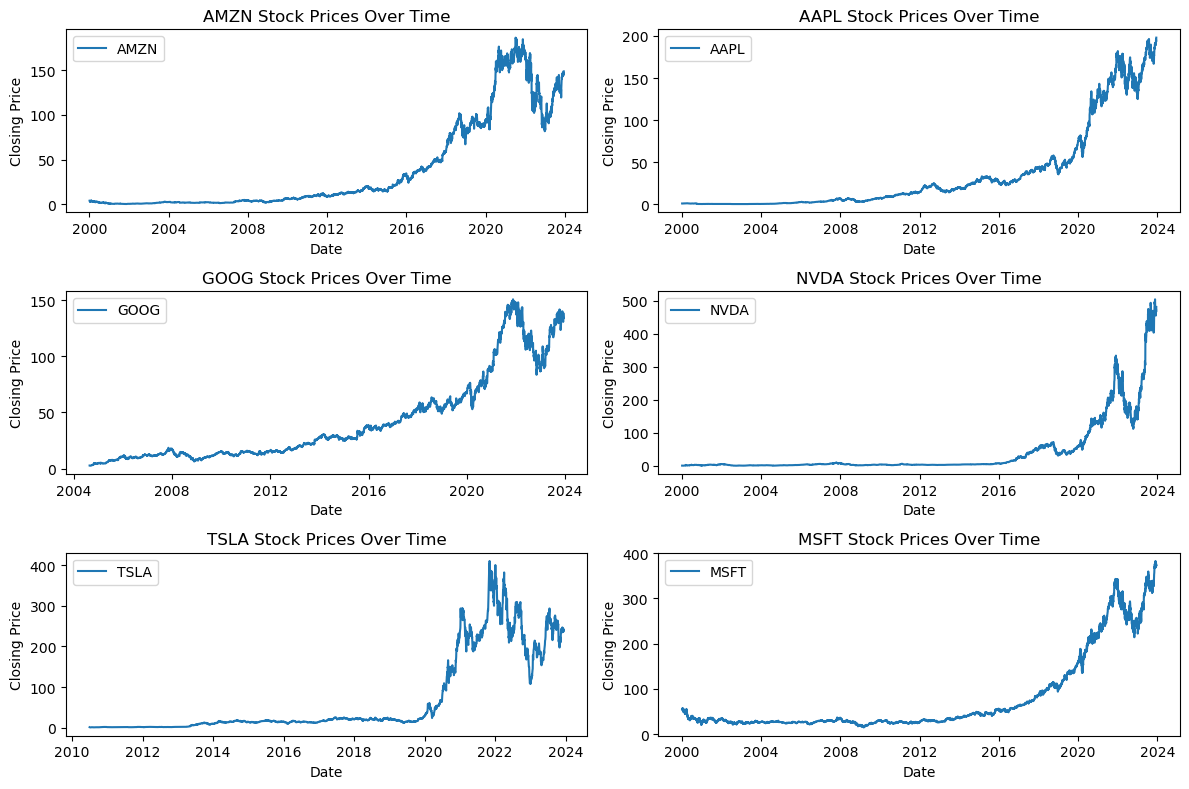

In [20]:
num_rows = len(df_dict) // 2 + len(df_dict) % 2 
num_cols = 2 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

axes = axes.flatten()

for i, (indice, df_indice) in enumerate(df_dict.items()):
    ax = axes[i]
    ax.plot(df_indice.index, df_indice['Close'], label=indice)
    ax.set_title(f'{indice} Stock Prices Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Closing Price')
    ax.legend()
plt.tight_layout()
plt.show()

# Evaluation des méthodes

In [21]:
# Initialiser le label encoder
label_encoder = LabelEncoder()


# Initialiser les modèles
models = {
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'SVM rbf': SVC(kernel='rbf'),
    'KNeighbors': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'NeuralNetwork': MLPClassifier(max_iter=500),
    'DecisionTree': DecisionTreeClassifier(),
    'LinearSVM': SVC(kernel='linear')
}

# Initialiser un dictionnaire pour stocker les performances des modèles par indice
model_performances_dict = {}

# Modélisation pour chaque indice
for indice, df_indice in df_dict.items():
    print(f"Modélisation pour l'indice {indice} :\n")

    # Sélectionner les caractéristiques et la variable cible pour l'indice actuel
    features_columns = [col for col in df_indice.columns if col != 'Variable_Cible']
    X = df_indice[features_columns]
    y = df_indice['Variable_Cible']

    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Encoder la variable cible
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Standardiser les caractéristiques
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    precision_scores = {}

    # Entraîner et évaluer chaque modèle pour l'indice actuel
    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        y_pred = model.predict(X_test_scaled)

        # Évaluer les performances
        accuracy = accuracy_score(y_test_encoded, y_pred)
        report = classification_report(y_test_encoded, y_pred, zero_division='warn')
        #confusion_mat = confusion_matrix(y_test_encoded, y_pred)
        
           # Calculate micro-average precision
        micro_precision = precision_score(y_test_encoded, y_pred, average='micro')
        macro_precision = precision_score(y_test_encoded, y_pred, average='macro')

        
        # Calculate precision for each class
        class_precision = precision_score(y_test_encoded, y_pred, average=None)
        
        hamming_loss_value = hamming_loss(y_test_encoded, y_pred)
        
        
        # Store precision scores in the dictionary
        precision_scores[model_name] = {'Micro Precision': micro_precision, 'Class Precision': class_precision}
        

        # Stocker les performances dans le dictionnaire
        if indice not in model_performances_dict:
            model_performances_dict[indice] = {}
        model_performances_dict[indice][model_name] = {'Accuracy': accuracy, 'Classification Report': report}

        # Afficher les performances pour chaque modèle
        print(f"Performance du modèle {model_name} :")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Classification Report:\n{report}\n")
        print(f"Hamming Loss: {hamming_loss_value:.4f}")
        print(f"Micro Precision: {micro_precision:.4f}")
        print(f"Macro Precision: {macro_precision:.4f}\n")
        #print(f"Class Precision: {class_precision}\n")
        #print(f"Confusion Matrix:\n{confusion_mat}\n")

Modélisation pour l'indice AMZN :

Performance du modèle RandomForest :
Accuracy: 0.6315
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.58      0.61       343
           1       0.68      0.74      0.70       444
           2       0.57      0.56      0.57       418

    accuracy                           0.63      1205
   macro avg       0.63      0.63      0.63      1205
weighted avg       0.63      0.63      0.63      1205


Hamming Loss: 0.3685
Micro Precision: 0.6315
Macro Precision: 0.6298

Performance du modèle GradientBoosting :
Accuracy: 0.4855
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.37      0.43       343
           1       0.48      0.55      0.51       444
           2       0.48      0.51      0.49       418

    accuracy                           0.49      1205
   macro avg       0.49      0.48      0.48      1205
weighted avg       0.49      

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

Performance du modèle LinearSVM :
Accuracy: 0.4430
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.31      0.07      0.12       308
           2       0.45      0.94      0.61       436

    accuracy                           0.44       973
   macro avg       0.26      0.34      0.24       973
weighted avg       0.30      0.44      0.31       973


Hamming Loss: 0.5570
Micro Precision: 0.4430
Macro Precision: 0.2557

Modélisation pour l'indice NVDA :

Performance du modèle RandomForest :
Accuracy: 0.6498
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67       386
           1       0.70      0.79      0.74       526
           2       0.47      0.42      0.44       293

    accuracy                           0.65      1205
   macro avg       0.62      0.61      0.62      1205
weighted avg       0.64      0.65   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

Performance du modèle LinearSVM :
Accuracy: 0.4365
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       386
           1       0.44      1.00      0.61       526
           2       0.00      0.00      0.00       293

    accuracy                           0.44      1205
   macro avg       0.15      0.33      0.20      1205
weighted avg       0.19      0.44      0.27      1205


Hamming Loss: 0.5635
Micro Precision: 0.4365
Macro Precision: 0.1455

Modélisation pour l'indice TSLA :

Performance du modèle RandomForest :
Accuracy: 0.6357
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.64      0.66       253
           1       0.66      0.78      0.72       274
           2       0.46      0.36      0.41       151

    accuracy                           0.64       678
   macro avg       0.60      0.60      0.60       678
weighted avg       0.63      0.64   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

Performance du modèle SVM rbf :
Accuracy: 0.4484
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.16      0.26       253
           1       0.43      0.96      0.59       274
           2       0.00      0.00      0.00       151

    accuracy                           0.45       678
   macro avg       0.37      0.37      0.28       678
weighted avg       0.43      0.45      0.33       678


Hamming Loss: 0.5516
Micro Precision: 0.4484
Macro Precision: 0.3718

Performance du modèle KNeighbors :
Accuracy: 0.5295
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.61      0.57       253
           1       0.57      0.65      0.61       274
           2       0.33      0.17      0.23       151

    accuracy                           0.53       678
   macro avg       0.48      0.48      0.47       678
weighted avg       0.51      0.53      0.51       678


Hamming Loss: 0.470

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

Performance du modèle LinearSVM :
Accuracy: 0.4248
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.11      0.19       253
           1       0.41      0.95      0.57       274
           2       0.00      0.00      0.00       151

    accuracy                           0.42       678
   macro avg       0.33      0.35      0.26       678
weighted avg       0.38      0.42      0.30       678


Hamming Loss: 0.5752
Micro Precision: 0.4248
Macro Precision: 0.3308

Modélisation pour l'indice MSFT :

Performance du modèle RandomForest :
Accuracy: 0.6515
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.49      0.56       273
           1       0.66      0.52      0.58       340
           2       0.65      0.80      0.72       592

    accuracy                           0.65      1205
   macro avg       0.65      0.60      0.62      1205
weighted avg       0.65      0.65   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

<Figure size 1200x800 with 0 Axes>

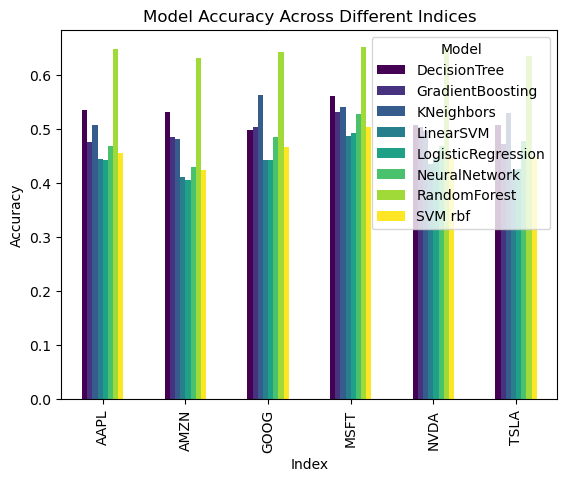

In [22]:
#Visualisation des précisions
from sklearn.metrics import classification_report
import seaborn as sns

df_performances = pd.DataFrame.from_dict({(i, j): model_performances_dict[i][j] 
                                           for i in model_performances_dict.keys() 
                                           for j in model_performances_dict[i].keys()},
                                         orient='index')

plt.figure(figsize=(12, 8))
df_performances['Accuracy'].unstack().plot(kind='bar', colormap='viridis')
plt.title('Model Accuracy Across Different Indices')
plt.xlabel('Index')
plt.ylabel('Accuracy')
plt.legend(title='Model')
plt.show()




On remarque que le modèle le plus perfermant est Random forest on a une précision qui atteint ~ 68%.

# D'autres Variables explicatives

In [ ]:
# Fonction pour ajouter l'indicateur VWAP
def add_vwap_column(df_indice):
    df_indice['TP'] = (df_indice['High'] + df_indice['Low'] + df_indice['Close']) / 3
    df_indice['TPV'] = df_indice['TP'] * df_indice['Volume']
    df_indice['VWAP'] = df_indice['TPV'].cumsum() / df_indice['Volume'].cumsum()

# Appliquer la fonction à chaque indice
for indice, df_indice in df_dict.items():
    add_vwap_column(df_indice)

In [ ]:
from ta.trend import CCIIndicator

# Fonction pour ajouter l'indicateur CCI
def add_cci_column(df_indice, window=20):
    df_indice['CCI'] = CCIIndicator(df_indice['High'], df_indice['Low'], df_indice['Close'], window=window).cci()

# Appliquer la fonction à chaque indice
for indice, df_indice in df_dict.items():
    add_cci_column(df_indice)

In [ ]:
for indice, df_indice in df_dict.items():
    columns_to_drop =['TP','TPV']
    df_indice.drop(columns=columns_to_drop, axis=1, inplace=True)

In [ ]:
# Fonction pour ajouter l'indicateur BOP
def add_bop_column(df_indice):
    df_indice['BOP'] = (df_indice['Close'] - df_indice['Open']) / (df_indice['High'] - df_indice['Low'])

# Appliquer la fonction à chaque indice
for indice, df_indice in df_dict.items():
    add_bop_column(df_indice)

In [ ]:
# Fonction pour ajouter l'indicateur stochastique
def add_stochastic_oscillator_columns(df_indice, window=14):
    df_indice['Stochastic_Oscillator'] = (df_indice['Close'] - df_indice['Low'].rolling(window=window).min()) / (df_indice['High'].rolling(window=window).max() - df_indice['Low'].rolling(window=window).min())

# Appliquer la fonction à chaque indice
for indice, df_indice in df_dict.items():
    add_stochastic_oscillator_columns(df_indice)

In [ ]:
import numpy as np
# Fonction pour ajouter l'indicateur WMA
def add_wma_column(df_indice, window=14):
    weights = list(range(1, window + 1))
    df_indice['WMA'] = df_indice['Close'].rolling(window=window).apply(lambda prices: np.dot(prices, weights) / sum(weights), raw=True)

# Appliquer la fonction à chaque indice
for indice, df_indice in df_dict.items():
    add_wma_column(df_indice)


In [29]:
for indice, df_indice in df_dict.items():
    df_dict[indice] = df_indice.dropna()


In [30]:
df_dict['AAPL']

,Open,High,Low,Close,Adj Close,Volume,Variable_Cible,MACD,MACD_Histogram,RSI_14,...,ATR_11,ATR_12,ATR_13,ATR_14,CMF,VWAP,CCI,BOP,Stochastic_Oscillator,WMA
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-01,0.928571,0.937500,0.892857,0.895089,0.758749,318035200,Hausse,-0.006266,0.000471,56.109966,...,0.062043,0.059012,0.058765,0.060308,-0.299259,0.927408,-22.389090,-0.749994,0.392858,0.946822
2000-02-02,0.899554,0.911830,0.866071,0.882254,0.747869,464195200,Hausse,-0.010236,-0.002799,60.152790,...,0.061688,0.060686,0.057993,0.057836,-0.349045,0.925932,-48.439855,-0.378068,0.217671,0.939966
2000-02-03,0.895647,0.930804,0.895089,0.922433,0.781928,475193600,Hausse,-0.010024,-0.002070,56.287450,...,0.060572,0.059524,0.058765,0.056401,-0.301309,0.925581,-6.062516,0.749993,0.326389,0.937479
2000-02-04,0.928013,0.982143,0.925223,0.964286,0.817406,425320000,Stable,-0.006406,0.001239,57.109346,...,0.059253,0.060268,0.059323,0.058634,-0.250985,0.926563,46.605394,0.637263,0.500002,0.940014
2000-02-07,0.964286,1.020089,0.945871,1.018415,0.863290,441067200,Stable,0.000820,0.006772,59.080736,...,0.062703,0.060500,0.061341,0.060387,-0.159373,0.928690,88.859142,0.729324,0.724538,0.949123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-07,193.630005,195.000000,193.589996,194.270004,194.270004,47477700,Stable,3.410293,-0.024239,63.302195,...,2.332728,2.286667,2.266923,2.234286,0.085348,13.495184,162.152204,0.453899,0.903312,191.359618
2023-12-08,194.199997,195.990005,193.669998,195.710007,195.710007,53377300,Stable,3.550769,0.092990,66.217673,...,2.352729,2.331668,2.289232,2.270715,0.105877,13.499204,183.883415,0.650864,0.967213,191.994762
2023-12-11,193.110001,193.490005,191.419998,193.179993,193.179993,60943700,Stable,3.418540,-0.031392,54.474891,...,2.390912,2.329169,2.311540,2.273573,0.173192,13.503733,84.264556,0.033812,0.670959,192.235238


In [31]:
# Initialiser le label encoder
label_encoder = LabelEncoder()


# Initialiser les modèles
models = {
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'SVM rbf': SVC(kernel='rbf'),
    'KNeighbors': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'NeuralNetwork': MLPClassifier(max_iter=500),
    'DecisionTree': DecisionTreeClassifier(),
    'LinearSVM': SVC(kernel='linear')
}

# Initialiser un dictionnaire pour stocker les performances des modèles par indice
model_performances_dict = {}

# Modélisation pour chaque indice
for indice, df_indice in df_dict.items():
    print(f"Modélisation pour l'indice {indice} :\n")

    # Sélectionner les caractéristiques et la variable cible pour l'indice actuel
    features_columns = [col for col in df_indice.columns if col != 'Variable_Cible']
    X = df_indice[features_columns]
    y = df_indice['Variable_Cible']

    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Encoder la variable cible
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Standardiser les caractéristiques
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    precision_scores = {}

    # Entraîner et évaluer chaque modèle pour l'indice actuel
    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        y_pred = model.predict(X_test_scaled)

        # Évaluer les performances
        accuracy = accuracy_score(y_test_encoded, y_pred)
        report = classification_report(y_test_encoded, y_pred, zero_division='warn')
        #confusion_mat = confusion_matrix(y_test_encoded, y_pred)
        
           # Calculate micro-average precision
        micro_precision = precision_score(y_test_encoded, y_pred, average='micro')
        macro_precision = precision_score(y_test_encoded, y_pred, average='macro')

        
        # Calculate precision for each class
        class_precision = precision_score(y_test_encoded, y_pred, average=None)
        
        hamming_loss_value = hamming_loss(y_test_encoded, y_pred)
        
        
        # Store precision scores in the dictionary
        precision_scores[model_name] = {'Micro Precision': micro_precision, 'Class Precision': class_precision}
        

        # Stocker les performances dans le dictionnaire
        if indice not in model_performances_dict:
            model_performances_dict[indice] = {}
        model_performances_dict[indice][model_name] = {'Accuracy': accuracy, 'Classification Report': report}

        # Afficher les performances pour chaque modèle
        print(f"Performance du modèle {model_name} :")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Classification Report:\n{report}\n")
        print(f"Hamming Loss: {hamming_loss_value:.4f}")
        print(f"Micro Precision: {micro_precision:.4f}")
        print(f"Macro Precision: {macro_precision:.4f}\n")
        #print(f"Class Precision: {class_precision}\n")
        #print(f"Confusion Matrix:\n{confusion_mat}\n")

Modélisation pour l'indice AMZN :

Performance du modèle RandomForest :
Accuracy: 0.6514
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65       346
           1       0.73      0.72      0.73       457
           2       0.55      0.58      0.57       399

    accuracy                           0.65      1202
   macro avg       0.65      0.65      0.65      1202
weighted avg       0.65      0.65      0.65      1202


Hamming Loss: 0.3486
Micro Precision: 0.6514
Macro Precision: 0.6502

Performance du modèle GradientBoosting :
Accuracy: 0.4725
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.39      0.43       346
           1       0.50      0.49      0.50       457
           2       0.44      0.52      0.48       399

    accuracy                           0.47      1202
   macro avg       0.48      0.47      0.47      1202
weighted avg       0.48      

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

Performance du modèle LinearSVM :
Accuracy: 0.4293
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       240
           1       0.40      0.07      0.11       323
           2       0.43      0.97      0.60       406

    accuracy                           0.43       969
   macro avg       0.28      0.35      0.24       969
weighted avg       0.32      0.43      0.29       969


Hamming Loss: 0.5707
Micro Precision: 0.4293
Macro Precision: 0.2782

Modélisation pour l'indice NVDA :

Performance du modèle RandomForest :
Accuracy: 0.6922
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       380
           1       0.73      0.83      0.78       507
           2       0.55      0.43      0.48       315

    accuracy                           0.69      1202
   macro avg       0.67      0.66      0.66      1202
weighted avg       0.68      0.69   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

Performance du modèle LinearSVM :
Accuracy: 0.4243
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.01      0.02       380
           1       0.42      1.00      0.59       507
           2       0.00      0.00      0.00       315

    accuracy                           0.42      1202
   macro avg       0.36      0.34      0.20      1202
weighted avg       0.39      0.42      0.26      1202


Hamming Loss: 0.5757
Micro Precision: 0.4243
Macro Precision: 0.3632

Modélisation pour l'indice TSLA :

Performance du modèle RandomForest :
Accuracy: 0.6736
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.73       232
           1       0.72      0.82      0.76       296
           2       0.41      0.32      0.36       146

    accuracy                           0.67       674
   macro avg       0.62      0.62      0.62       674
weighted avg       0.66      0.67   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

Performance du modèle SVM rbf :
Accuracy: 0.4555
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.15      0.23       232
           1       0.45      0.92      0.60       296
           2       0.00      0.00      0.00       146

    accuracy                           0.46       674
   macro avg       0.32      0.36      0.28       674
weighted avg       0.38      0.46      0.34       674


Hamming Loss: 0.5445
Micro Precision: 0.4555
Macro Precision: 0.3238

Performance du modèle KNeighbors :
Accuracy: 0.4852
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.56      0.50       232
           1       0.56      0.59      0.57       296
           2       0.29      0.14      0.19       146

    accuracy                           0.49       674
   macro avg       0.43      0.43      0.42       674
weighted avg       0.46      0.49      0.47       674


Hamming Loss: 0.514

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

Performance du modèle LinearSVM :
Accuracy: 0.4525
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.11      0.19       232
           1       0.44      0.94      0.60       296
           2       0.00      0.00      0.00       146

    accuracy                           0.45       674
   macro avg       0.33      0.35      0.26       674
weighted avg       0.39      0.45      0.33       674


Hamming Loss: 0.5475
Micro Precision: 0.4525
Macro Precision: 0.3327

Modélisation pour l'indice MSFT :

Performance du modèle RandomForest :
Accuracy: 0.6647
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.56      0.59       241
           1       0.69      0.54      0.61       356
           2       0.67      0.78      0.72       605

    accuracy                           0.66      1202
   macro avg       0.66      0.63      0.64      1202
weighted avg       0.67      0.66   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

<Figure size 1200x800 with 0 Axes>

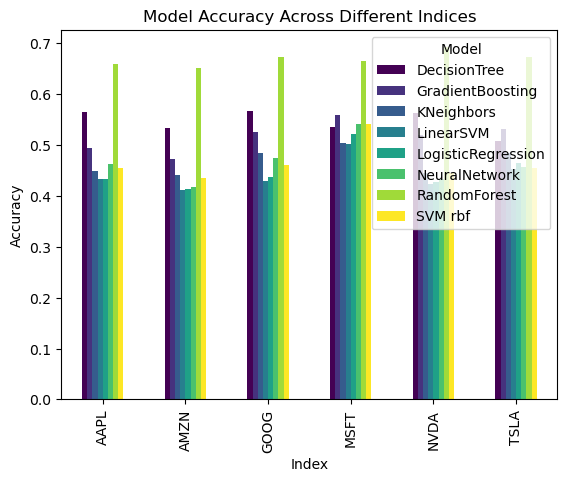

In [32]:
from sklearn.metrics import classification_report
import seaborn as sns

df_performances = pd.DataFrame.from_dict({(i, j): model_performances_dict[i][j] 
                                           for i in model_performances_dict.keys() 
                                           for j in model_performances_dict[i].keys()},
                                         orient='index')
plt.figure(figsize=(12, 8))
df_performances['Accuracy'].unstack().plot(kind='bar', colormap='viridis')
plt.title('Model Accuracy Across Different Indices')
plt.xlabel('Index')
plt.ylabel('Accuracy')
plt.legend(title='Model')
plt.show()
